In [1]:
import numpy as np
import matplotlib.pyplot as plt

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/simgraph/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import dataprocess.data_handler_03 as dh

# Load spike data

Spike data shape:  (297, 1141, 113) $\implies$ (movie repeats, frames/time, neurons)
<br>
Labels are 1 (= spike) or -1 (= no spike).

In [3]:
# load all spike data from file
spikes_dp = '../../../local_data/original_files/'
binned_data = np.load(spikes_dp+'spikes.npy')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1     # turn labels from 0,1 to -1,1

In [4]:
I_order = np.array([ 54,  35,  10,  60,  74,   9,  61,  56,  91, 104,  39,   7,  29,  68,  81,  41,  75 , 76,
   82,  79,  32,  51,  14,  88,  89,   8, 107,   3,  80,  55, 106,  96,  94, 95,   6,  20,
   83,  87,   1,  97, 103,  28,  18,  16,  85, 101,   2,  52,  11,  71, 108,  38,  25,  53,
  113,  64,  58,  24,  70,  43,  77,  45, 110,  49,  26,  40,  48,  67, 100,  30,  19,  36,
   17,   5,  69,  65,  99, 78,  33,  37,  47,  66,  59,  98,  21,  90,  12,  46,  86,  92,
    4, 112,  62,  50, 105,  27,  13,  93, 102,  63,  34,  31,  84,  23,  44,  15, 109, 111,
   72,  73,  42,  57,  22])
I_order = I_order - 1

In [5]:
# print some statistics
print('binned_data.shape = ', binned_data.shape)

avg_spike_perc = 0
print('neuron #    | percentage belonging to class 1')
print('---------------------------------------------')
for neu_i in I_order[:10]:
    pers = dh.class_percentages(binned_data[:,:,neu_i].reshape(-1), [-1, 1])
    avg_spike_perc += pers[1]
    print('neuron #{:3} | {:.2f} %'.format(neu_i, pers[1]))

avg_spike_perc /= 10
print('---------------------------------------------')
print('AVERAGE     | {:.2f} % of data belongs to class 1'.format(avg_spike_perc))

total_perc = np.sum(binned_data == 1) * 100 / len(binned_data.reshape(-1))
print('---------------------------------------------')
print('{:.2f} % of the whole data belongs to class 1.'.format(total_perc))

binned_data.shape =  (297, 1141, 113)
neuron #    | percentage belonging to class 1
---------------------------------------------
neuron # 53 | 0.44 %
neuron # 34 | 0.37 %
neuron #  9 | 0.64 %
neuron # 59 | 0.50 %
neuron # 73 | 0.78 %
neuron #  8 | 1.03 %
neuron # 60 | 1.42 %
neuron # 55 | 0.28 %
neuron # 90 | 0.29 %
neuron #103 | 0.97 %
---------------------------------------------
AVERAGE     | 0.67 % of data belongs to class 1
---------------------------------------------
3.00 % of the whole data belongs to class 1.


# Group neurons

This will create a more balanced dataset which is presumabley easier to solve.

## 1. Naively group all 113 neurons.

Spike data shape:  (297, 1141, 1) $\implies$ (movie repeats, frames/time, group)

In [7]:
# group all neurons together
grouped_data = np.zeros((297, 1141, 1))
for trial in range(297):
    for frame in range(1141):
        grouped_data[trial, frame, :] = 2 * int((binned_data[trial, frame, :] == 1).any()) - 1

In [8]:
# print some statistics
print('grouped_data.shape = ', grouped_data.shape)

avg_spike_perc = 0
print('trial #    | percentage belonging to class 1')
print('---------------------------------------------')
for trial in range(10):
    pers = dh.class_percentages(grouped_data[trial, :, :].reshape(-1), [-1, 1])
    avg_spike_perc += pers[1]
    print('trial #{:3} | {:.2f} %'.format(trial, pers[1]))

avg_spike_perc /= 10
print('---------------------------------------------')
print('AVERAGE     | {:.2f} %'.format(avg_spike_perc))

total_perc = np.sum(grouped_data == 1) *100 /(grouped_data.shape[0] * grouped_data.shape[1])
print('---------------------------------------------')
print('{:.2f} % of the whole data belongs to class 1.'.format(total_perc))

grouped_data.shape =  (297, 1141, 1)
trial #    | percentage belonging to class 1
---------------------------------------------
trial #  0 | 66.26 %
trial #  1 | 69.06 %
trial #  2 | 67.92 %
trial #  3 | 71.08 %
trial #  4 | 68.97 %
trial #  5 | 68.27 %
trial #  6 | 66.87 %
trial #  7 | 65.82 %
trial #  8 | 67.66 %
trial #  9 | 68.19 %
---------------------------------------------
AVERAGE     | 68.01 %
---------------------------------------------
68.47 % of the whole data belongs to class 1.


In [9]:
# save the group response signal
np.save(spikes_dp+'grouped_spikes.npy', grouped_data)

## 2. Sum the activities of neurons

In [10]:
# sum the activities into one single response
summed_data = np.zeros((297, 1141, 1))
for trial in range(297):
    for frame in range(1141):
        summed_data[trial, frame, :] = sum(binned_data[trial, frame, :] == 1)

In [11]:
# print some statistics
print('summed_data.shape = ', summed_data.shape)

length = summed_data.shape[0] * summed_data.shape[1]
lbl_min = int(np.min(summed_data))
lbl_max = int(np.max(summed_data))
print('labels range from {} to {}.'.format(lbl_min, lbl_max))

print('label      | percentage belonging to label   ')
print('---------------------------------------------')
sanity = 0
for lbl in range(lbl_min, lbl_max+1):
    class_perc = 100*float(sum(sum(summed_data == lbl))) / length
    print('label #{:3} | {:.2f} %'.format(lbl, class_perc))
    sanity += class_perc

print("total percentage (should be %100): ", sanity)

summed_data.shape =  (297, 1141, 1)
labels range from 0 to 26.
label      | percentage belonging to label   
---------------------------------------------
label #  0 | 31.53 %
label #  1 | 15.38 %
label #  2 | 8.77 %
label #  3 | 7.07 %
label #  4 | 6.27 %
label #  5 | 5.61 %
label #  6 | 4.82 %
label #  7 | 4.22 %
label #  8 | 3.67 %
label #  9 | 3.12 %
label # 10 | 2.60 %
label # 11 | 2.07 %
label # 12 | 1.61 %
label # 13 | 1.19 %
label # 14 | 0.80 %
label # 15 | 0.52 %
label # 16 | 0.31 %
label # 17 | 0.18 %
label # 18 | 0.11 %
label # 19 | 0.06 %
label # 20 | 0.04 %
label # 21 | 0.02 %
label # 22 | 0.01 %
label # 23 | 0.01 %
label # 24 | 0.00 %
label # 25 | 0.00 %
label # 26 | 0.00 %
total percentage (should be %100):  100.00000000000003


In [13]:
# save the new response signal
np.save(spikes_dp+'summed_spikes.npy', summed_data)

## 3. Group neurons that spike close to each other
What is the exact definition of "temporally close" in this context?
<br>
Get pairwise correlations.

### Visualize the spikes

In [68]:
trialids = np.array([1]) # which trials to show
# the following two variables define the specific shot of the trial to show
nframes2show = 1141
startframe = 0
cells2show = I_order[:10] # which cells to show
ntrials = trialids.shape[0]
ncells2show = cells2show.shape[0]

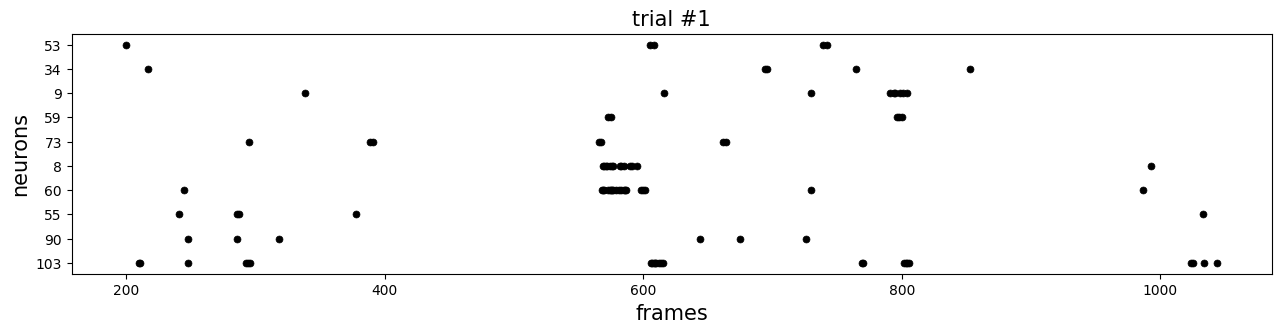

In [69]:
# plot defined spike graphs
x = np.arange(startframe, startframe+nframes2show)
X = np.broadcast_to(x[np.newaxis, :], (ncells2show, nframes2show))

y = np.arange(ncells2show, 0, -1).astype(float)
Y = np.outer(y, np.ones(nframes2show))

plt.figure(figsize = (15, ncells2show*ntrials//3))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

for i in range(ntrials):
    # select defined spike graphs
    z = binned_data[trialids[i], startframe:startframe+nframes2show, cells2show].astype(float)
    
    Z = Y.copy()
    Z[z == -1] = np.nan # only active neurons will be shown in the plot, any nonvisible neuron is inactive

    plt.subplot(ntrials, 1, i+1)
    _ = plt.plot(X, Z, marker='o', markersize=5, markeredgewidth=0.5, linestyle='', color='black')
    plt.tick_params(axis='x', which='major', labelsize=10)
    plt.yticks(y, cells2show)
    plt.xlabel('frames', fontsize = 15)
    plt.ylabel('neurons', fontsize = 15)
    plt.title('trial #{}'.format(trialids[i]), fontsize=15)

### Compute correlations

In [70]:
target = I_order[0]

target_curve = binned_data[:,:,target].reshape(-1)

# for mem in I_order[I_order != target]:
#     mem_curve = binned_data[:,:,mem].reshape(-1)
#     corr = np.sum(mem_curve * target_curve) / target_curve.shape[0]

corrs = [np.sum(binned_data[:,:,mem].reshape(-1) * target_curve) / target_curve.shape[0] for mem in I_order[I_order != target]]
corrs = np.array(sorted(corrs, reverse=True))
plt.plot(np.arange(corrs.shape[0]), corrs)

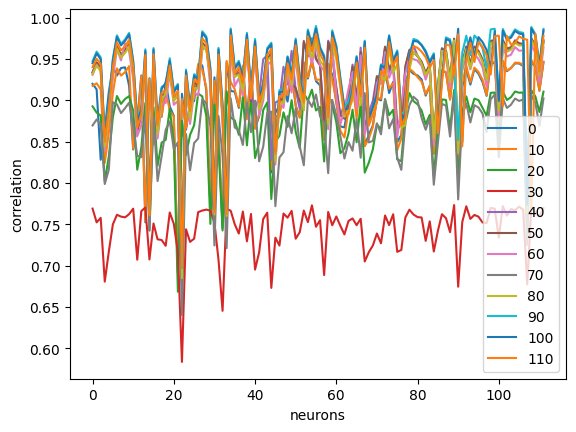

In [109]:
plt.figure()
neurons = np.arange(113)
targets = np.arange(0, 113, 10)
for target in targets:
    target_curve = binned_data[:,:,target].reshape(-1)
    corrs = [np.sum(binned_data[:,:,mem].reshape(-1) * target_curve) / target_curve.shape[0] for mem in neurons[neurons != target]]
    corrs = np.array(corrs)
    # corrs = np.array(sorted(corrs, reverse=True))
    plt.plot(np.arange(corrs.shape[0]), corrs)
plt.xlabel('neurons')
plt.ylabel('correlation')
plt.legend(targets)
plt.show()